In [85]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [86]:
options = {
    "working electrode": "positive",
    "thermal": "x-full",
}

model = pybamm.lithium_ion.BasicDFNHalfCell(options=options)

## utility functions / submodels

In [87]:
T = pybamm.Parameter("Temperature [K]")
R = pybamm.Parameter("Molar gas constant [J.mol-1.K-1]")
F = pybamm.Parameter("Faraday constant [C.mol-1]")


def cation_transference_number(c_e, T):
    return 0.0107907 + 1.48837e-4 * c_e


def open_circuit_potential(c_s_p):
    return 2.7 + (R * T / F) * (-0.000558 * c_s_p + 8.10)


def current_function(t):
    return 0.25 * ( t % 1200 <= 600)

## select and update parameters

In [88]:
# default parameters
chemistry = pybamm.parameter_sets.Chen2020
param = pybamm.ParameterValues(chemistry=chemistry)

param.update(
    {
        "Cation transference number": cation_transference_number,
        "Discharge capacity [A.h]": 50,
        "EC diffusivity [m2.s-1]": 7.5e-12,
        "EC initial concentration in electrolyte [mol.m-3]": 1000,
        "Electrode cross-sectional area [m2]": 1,
        "Electrolyte diffusivity [m2.s-1]": 7.5e-12,
        "Faraday constant [C.mol-1]": 96485,
        "Initial concentration in electrolyte [mol.m-3]": 1000,
        "Lithium counter electrode exchange-current density [A.m-2]": 12.6,
        "Lithium counter electrode conductivity [S.m-1]": 1.0776e7,
        "Lithium counter electrode thickness [m]": 50e-6,
        "Lower voltage cut-off [V]": 1.7,
        "Maximum concentration in the solid [mol.m-3]": 29000,
#         "Maximum concentration in positive electrode [mol.m-3]": 3920,
#         "Maximum working particle surface concentration [mol.m-3]": 3920,
        "Molar gas constant [J.mol-1.K-1]": 8.314,
        "Positive electrode active material volume fraction": 0.65,
        "Positive electrode diffusivity [m2.s-1]": 5e-13,
        "Positive electrode OCP [V]": open_circuit_potential,
        'Positive electrode thickness [m]': 100e-06,
        "Positive electrode porosity": 30e-2,
        "Positive particle radius [m]": 1e-6,
        "Separator porosity": 0.3,
        "Separator thickness [m]": 50e-6,
        "Temperature [K]": 373.15,
    },
    check_already_exists=False,
)

param["Initial concentration in negative electrode [mol.m-3]"] = 1000
param["Current function [A]"] = current_function

## geometry of the cell

In [89]:
# set geometry
geometry = model.default_geometry

In [90]:
param.process_geometry(geometry)

## mesh for discretization

In [91]:
# set mesh
var_pts = model.default_var_pts
mesh = pybamm.Mesh(geometry, model.default_submesh_types, var_pts)

In [92]:
param.process_model(model)
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model);

## solution

In [93]:
solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-3)

In [94]:
t_eval = np.linspace(0, 900, 30)
solution = solver.solve(model, t_eval)

Widget Javascript not detected.  It may not be installed or enabled properly.


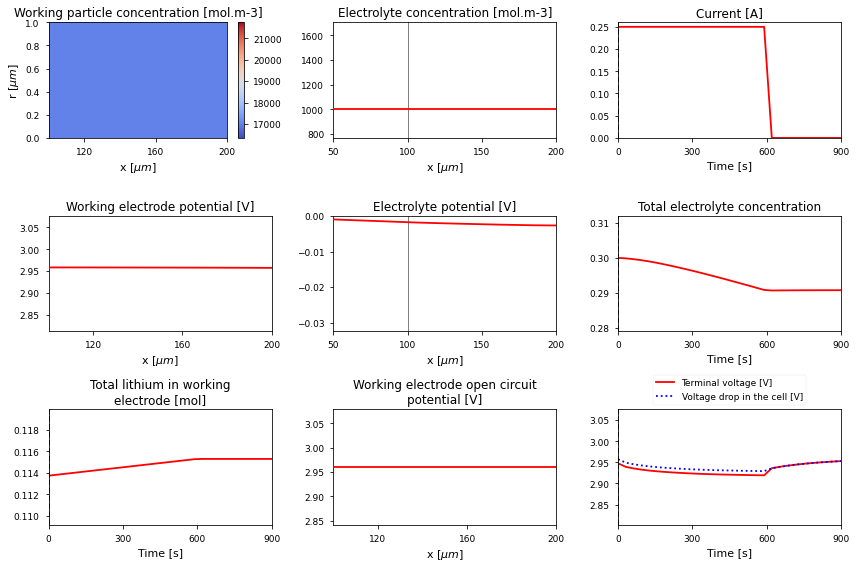

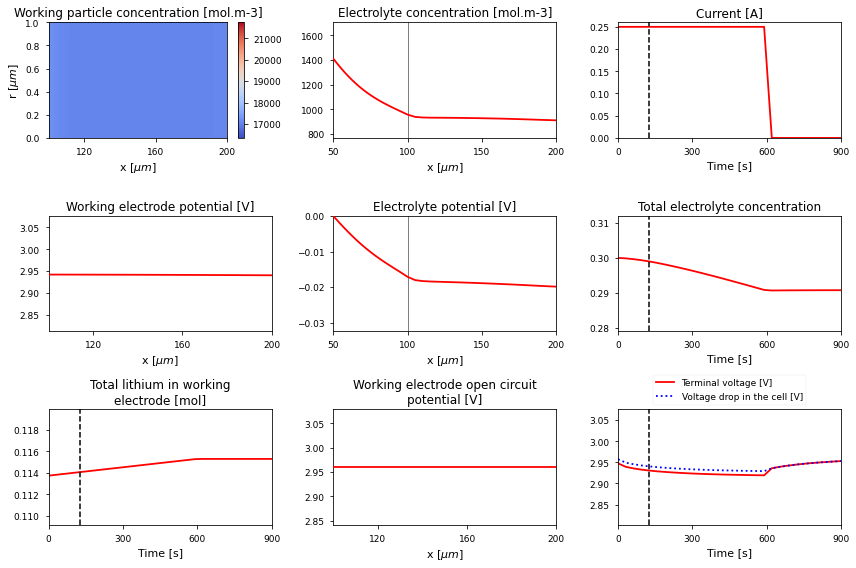

In [95]:
# plot
plot = pybamm.QuickPlot(
    solution,
    [
        "Working particle concentration [mol.m-3]",
        "Electrolyte concentration [mol.m-3]",
        "Current [A]",
        "Working electrode potential [V]",
        "Electrolyte potential [V]",
        "Total electrolyte concentration",
        "Total lithium in working electrode [mol]",
        "Working electrode open circuit potential [V]",
        ["Terminal voltage [V]", "Voltage drop in the cell [V]"],
    ],
    time_unit="seconds",
    spatial_unit="um",
)
plot.dynamic_plot()

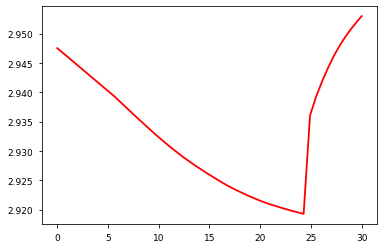

In [96]:
# solution["X-averaged working particle surface concentration [mol.m-3]"].data
# param["Cation transference number"]
# model.param.c_p_max
plt.plot(solution["Time [s]"].data**0.5, solution["Terminal voltage [V]"].data)

## features or artifacts
#### terminal voltage plot varying with separator porosity
- plot of terminal voltage vs time shows drop then rise for low separator porosity (0.05)
- 